# Implementation Of Attention Unet

Batch images shape: (8, 256, 256, 3)
Batch masks shape: (8, 256, 256, 11)


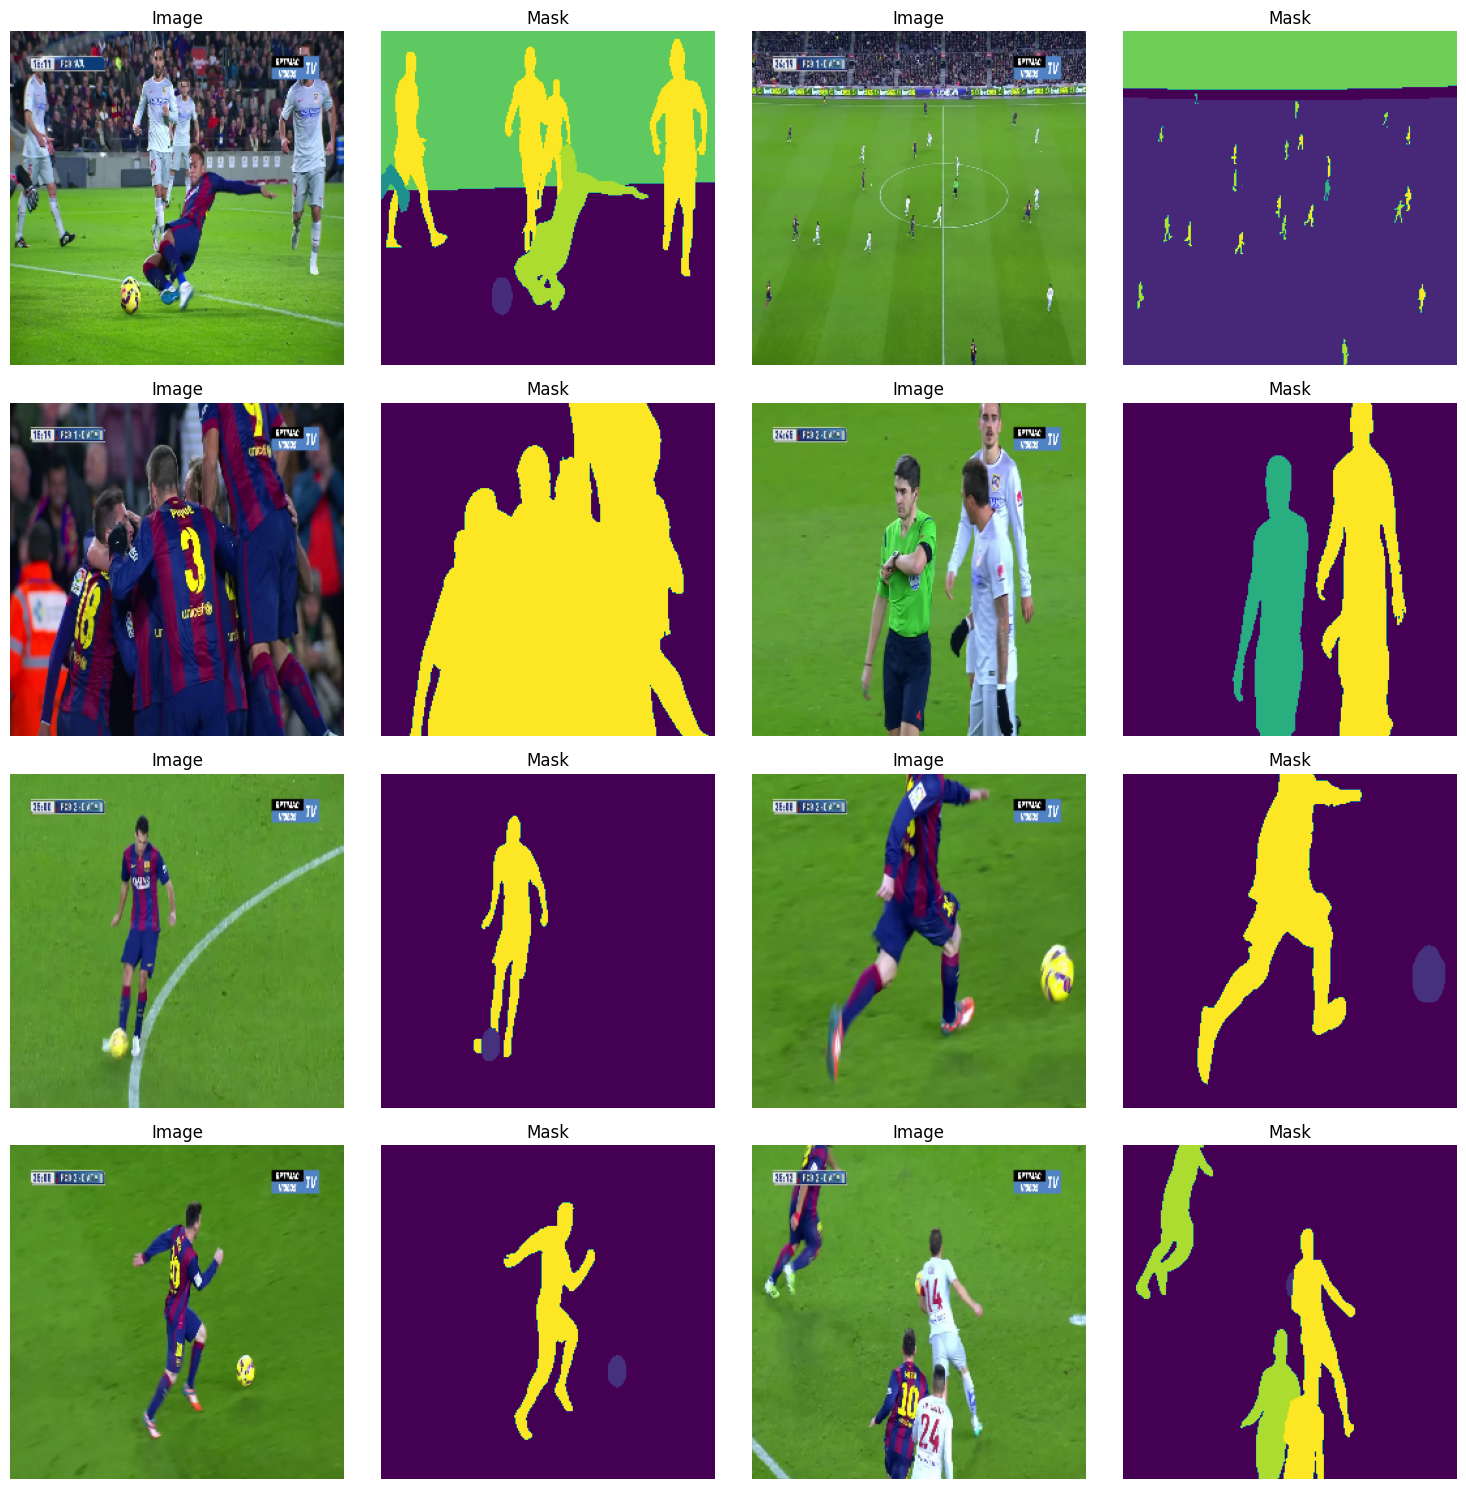

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# Load the CSV file
labels_df = pd.read_csv('/kaggle/input/football-match-semantic-segmentation/Labels and Colors.csv')

# Create a mapping from RGB to label index
rgb_to_label = {tuple(map(int, row[1].split(','))): idx for idx, row in enumerate(labels_df.values)}

# Define paths
image_folder = '/kaggle/input/football-match-semantic-segmentation/images'
mask_folder = '/kaggle/input/football-match-semantic-segmentation/masks'

# Get sorted lists of image and mask files
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Number of classes
num_classes = len(rgb_to_label)

# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, image_folder, mask_folder, batch_size, num_classes, rgb_to_label, target_size=(256, 256)):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.rgb_to_label = rgb_to_label
        self.target_size = target_size  # Target size for resizing
    
    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        masks = []
        
        for img_file, mask_file in zip(batch_x, batch_y):
            # Load and preprocess image
            img = cv2.imread(os.path.join(self.image_folder, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)  # Resize image
            img = img.astype(np.float32) / 255.0
            images.append(img)
            
            # Load and preprocess mask
            mask = cv2.imread(os.path.join(self.mask_folder, mask_file))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)  # Resize mask
            mask_label = np.zeros(mask.shape[:2], dtype=np.uint8)
            for rgb, label in self.rgb_to_label.items():
                mask_label[(mask == rgb).all(axis=-1)] = label
            masks.append(mask_label)
        
        images = np.array(images)
        masks = np.array(masks)
        
        # Convert masks to categorical
        masks_categorical = np.eye(self.num_classes)[masks]
        
        return images, masks_categorical

# Function to visualize a batch of images and masks in a grid
def visualize_batch(images, masks, num_samples=8, grid_size=(4, 4)):
    """
    Visualize a batch of images and masks in a grid.
    
    Args:
        images (np.ndarray): Batch of images (batch_size, height, width, 3).
        masks (np.ndarray): Batch of masks (batch_size, height, width, num_classes).
        num_samples (int): Number of samples to visualize.
        grid_size (tuple): Grid size for visualization (rows, cols).
    """
    fig, axes = plt.subplots(*grid_size, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_samples):
        # Display the image
        ax = axes[i * 2]
        ax.imshow(images[i])
        ax.set_title("Image")
        ax.axis("off")
        
        # Display the mask
        ax = axes[i * 2 + 1]
        ax.imshow(np.argmax(masks[i], axis=-1), cmap="viridis")  # Convert one-hot mask back to label map
        ax.set_title("Mask")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Parameters
batch_size = 8
target_size = (256, 256)  # Desired size for resizing

# Create data generator
train_generator = DataGenerator(image_files, mask_files, image_folder, mask_folder, batch_size, num_classes, rgb_to_label, target_size)

# Test the generator and visualize the first batch
for x, y in train_generator:
    print("Batch images shape:", x.shape)  
    print("Batch masks shape:", y.shape)   
    
    # Visualize the batch
    visualize_batch(x, y, num_samples=batch_size, grid_size=(4, 4))
    break

# U-net Model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define U-Net model
def unet(input_size=(256, 256, 3), num_classes=11):
    inputs = Input(input_size)
    
    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Upsample
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2, up1], axis=-1)
    
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1, up2], axis=-1)
    
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv5)
    
    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = unet(input_size=(256, 256, 3), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
epochs = 20
model.fit(train_generator, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 944ms/step - accuracy: 0.3550 - loss: 1.9241
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.4991 - loss: 1.2896
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.6665 - loss: 0.9778
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.7579 - loss: 0.7592
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.7859 - loss: 0.6437
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.8061 - loss: 0.6138
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.8006 - loss: 0.5960
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step - accuracy: 0.8333 - loss: 0.5369
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.8598 - loss: 0.4435
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.8329 - loss: 0.5207
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.8636 - loss: 0.4435
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/ste

In [3]:
images = '/kaggle/input/football-match-semantic-segmentation/images'
masks ='/kaggle/input/football-match-semantic-segmentation/masks'

# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


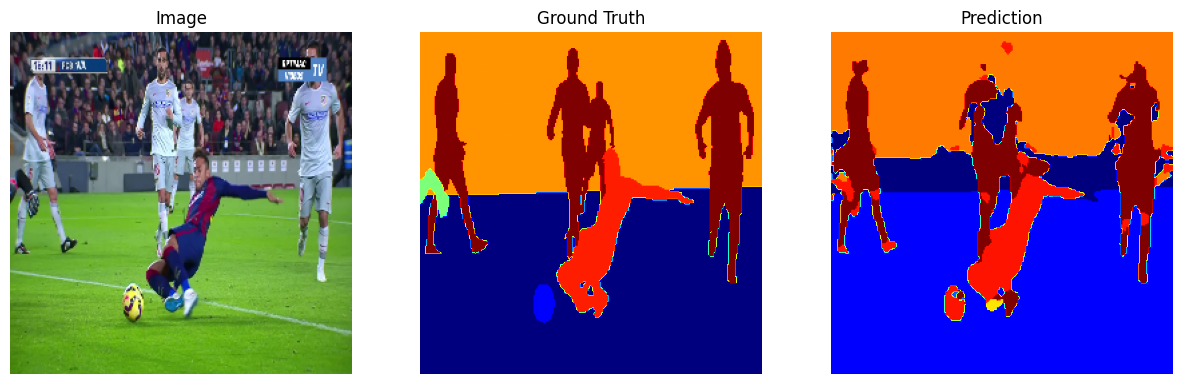

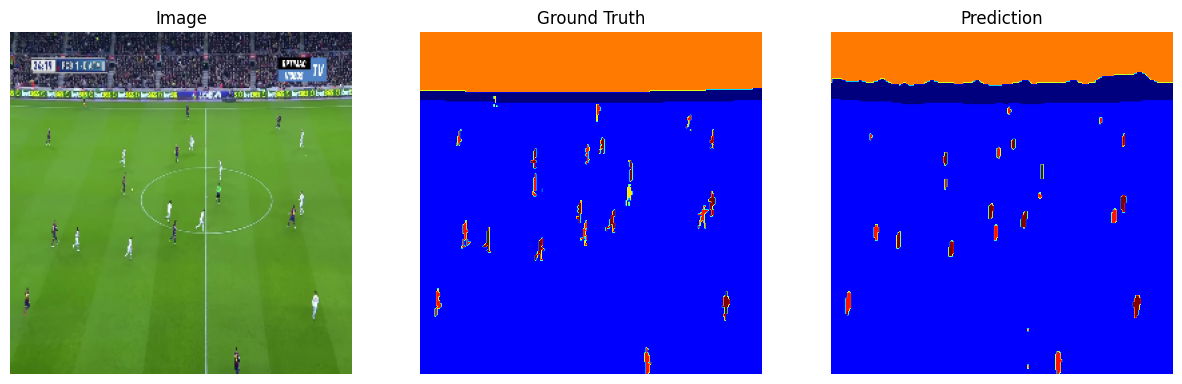

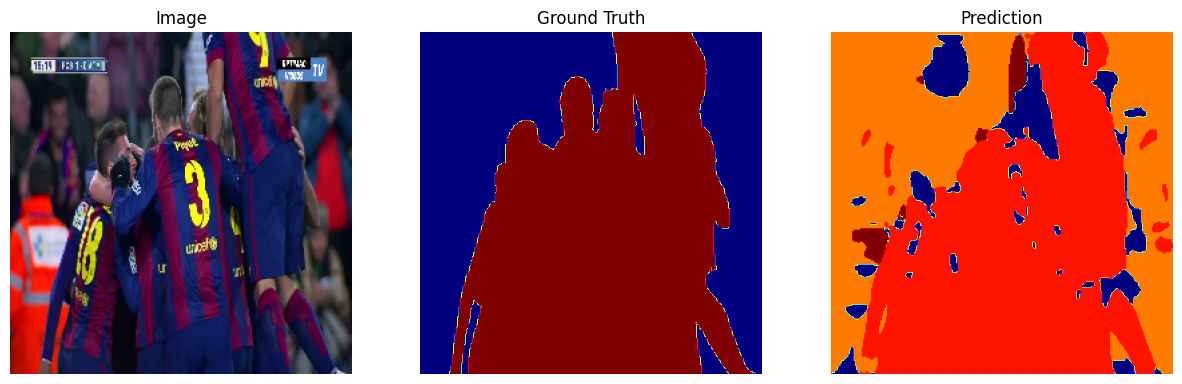

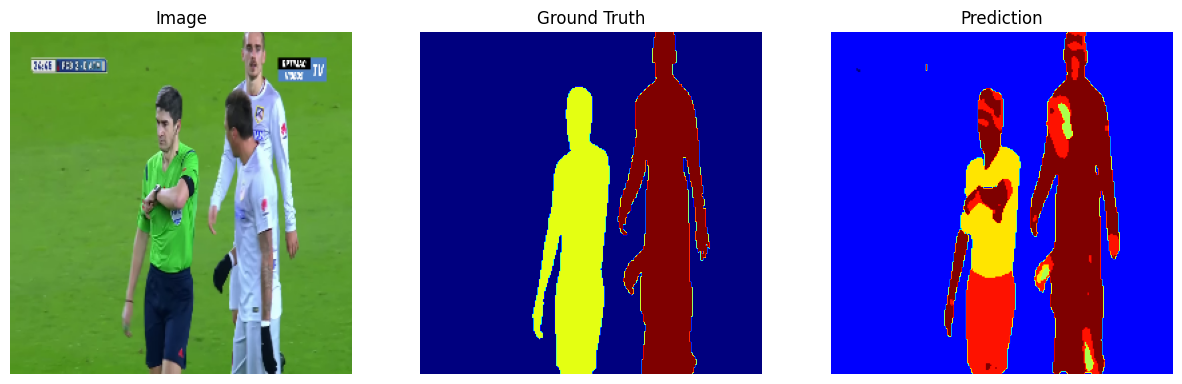

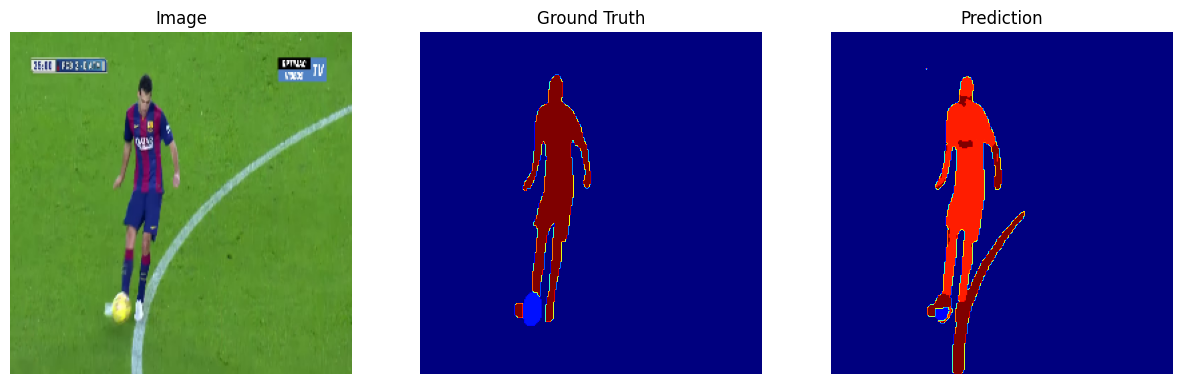

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_sample(image, mask, pred_mask):
    """
    Plots the original image, ground truth mask, and predicted mask.
    
    Args:
        image (np.array): Original image of shape (256, 256, 3).
        mask (np.array): Ground truth mask of shape (256, 256).
        pred_mask (np.array): Predicted mask of shape (256, 256).
    """
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.axis('off')
    
    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(mask, cmap='jet')  
    plt.axis('off')
    
    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred_mask, cmap='jet')  
    plt.axis('off')
    
    plt.show()

# Select a few samples for prediction
sample_indices = range(5)  
sample_images = []
sample_masks = []

for idx in sample_indices:
    # Load image
    img_path = os.path.join(image_folder, image_files[idx])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Unable to load image at {img_path}. Skipping.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load mask
    mask_path = os.path.join(mask_folder, mask_files[idx])
    mask = cv2.imread(mask_path)
    if mask is None:
        print(f"Warning: Unable to load mask at {mask_path}. Skipping.")
        continue
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # Convert mask to label indices
    mask_label = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, label in rgb_to_label.items():
        mask_label[(mask == rgb).all(axis=-1)] = label
    
    sample_images.append(img)
    sample_masks.append(mask_label)

# Ensure the images are in the correct shape and type
sample_images = [cv2.resize(img, (256, 256)) for img in sample_images]
sample_images = np.array(sample_images, dtype=np.float32) / 255.0

# Resize ground truth masks to match the model output size
sample_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) for mask in sample_masks]
sample_masks = np.array(sample_masks, dtype=np.uint8)

# Predict using the model
pred_masks = model.predict(sample_images)  # Output shape: (batch_size, 256, 256, num_classes)
pred_masks = np.argmax(pred_masks, axis=-1)  # Convert to class labels

# Plot the results
for img, true_mask, pred_mask in zip(sample_images, sample_masks, pred_masks):
    plot_sample(img, true_mask, pred_mask)

# Attention Unet

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Multiply, Add, Activation, GlobalAveragePooling2D, Reshape

# Define the Attention Gate
def attention_gate(input_g, input_x, inter_channels):
    """
    Attention gate to focus on relevant features during upsampling.
    
    Args:
        input_g: Gating signal from the upsampling path.
        input_x: Skip connection from the downsampling path.
        inter_channels: Intermediate number of filters.
    """
    # Transform gating signal
    theta_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(input_g)
    theta_g = Activation('relu')(theta_g)
    
    # Transform skip connection
    phi_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(input_x)
    phi_x = Activation('relu')(phi_x)
    
    # Add the transformed gating signal and skip connection
    add = Add()([theta_g, phi_x])
    add = Activation('relu')(add)
    
    # Compute attention coefficients
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(add)
    psi = Activation('sigmoid')(psi)
    
    # Apply attention coefficients to the skip connection
    attention = Multiply()([input_x, psi])
    
    return attention

def unet_with_attention(input_size=(256, 256, 3), num_classes=11):
    inputs = Input(input_size)
    
    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Upsample with Attention Gates
    up1 = UpSampling2D(size=(2, 2))(conv4)
    att1 = attention_gate(up1, conv3, inter_channels=256)
    up1 = concatenate([att1, up1], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up2 = UpSampling2D(size=(2, 2))(conv5)
    att2 = attention_gate(up2, conv2, inter_channels=128)
    up2 = concatenate([att2, up2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up3 = UpSampling2D(size=(2, 2))(conv6)
    att3 = attention_gate(up3, conv1, inter_channels=64)
    up3 = concatenate([att3, up3], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv7)
    
    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = unet_with_attention(input_size=(256, 256, 3), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
epochs = 30
model.fit(train_generator, epochs=epochs)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 987ms/step - accuracy: 0.4448 - loss: 3.2086
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.2654 - loss: 1.8068
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.4774 - loss: 1.3902
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - accuracy: 0.7447 - loss: 0.9073
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/step - accuracy: 0.7815 - loss: 0.7010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.7970 - loss: 0.6144
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.7931 - loss: 0.6443
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.8072 - loss: 0.5903
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.8200 - loss: 0.5586
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.8431 - loss: 0.5030
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 420ms/step - accuracy: 0.8197 - loss: 0.5517
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12

# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


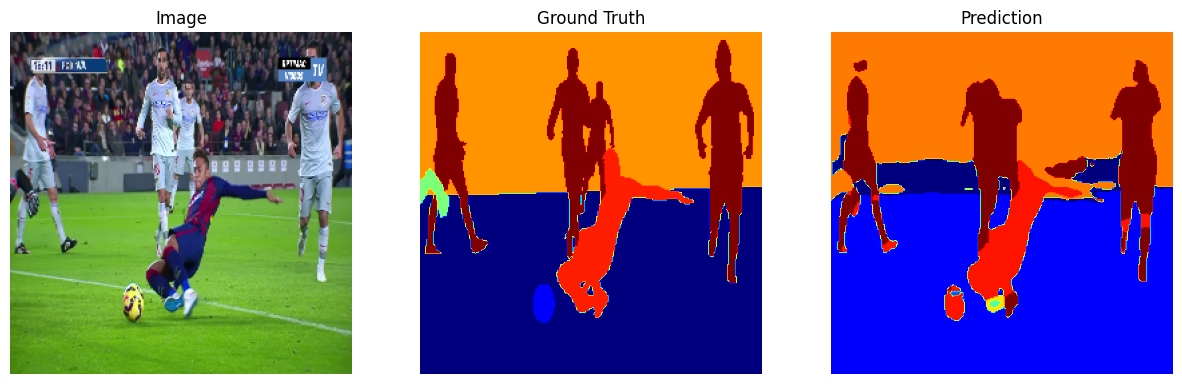

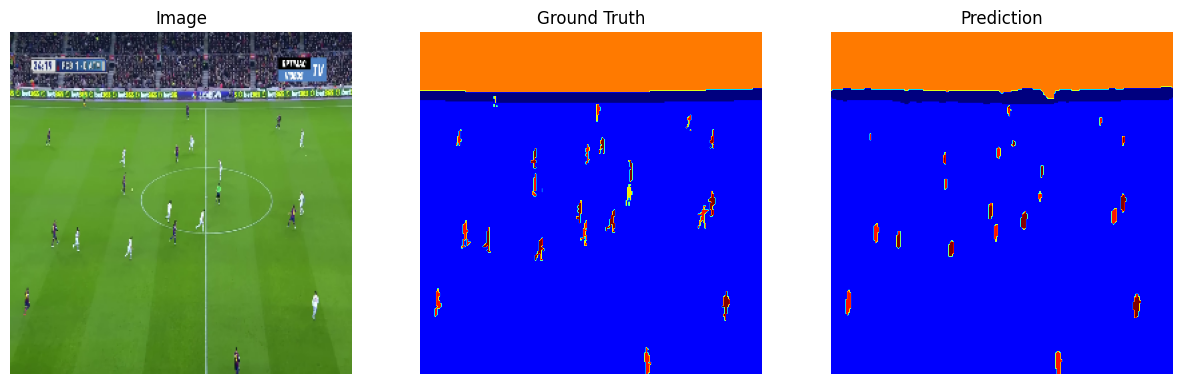

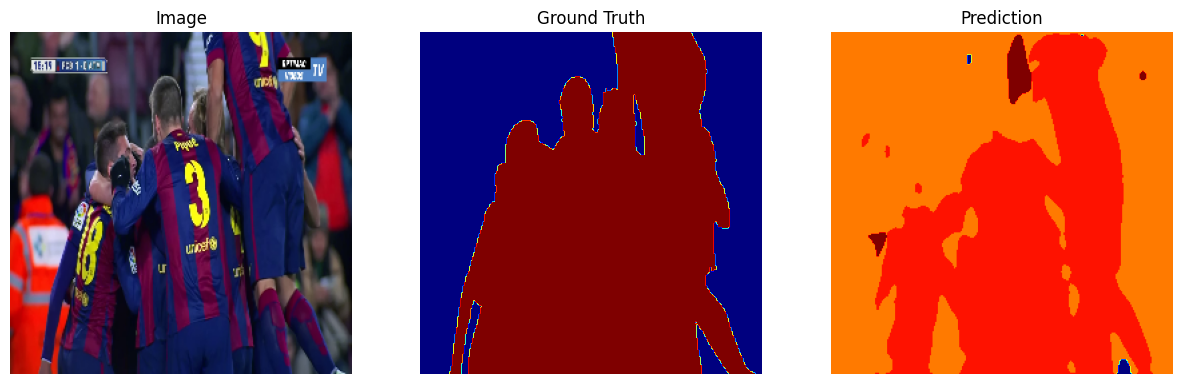

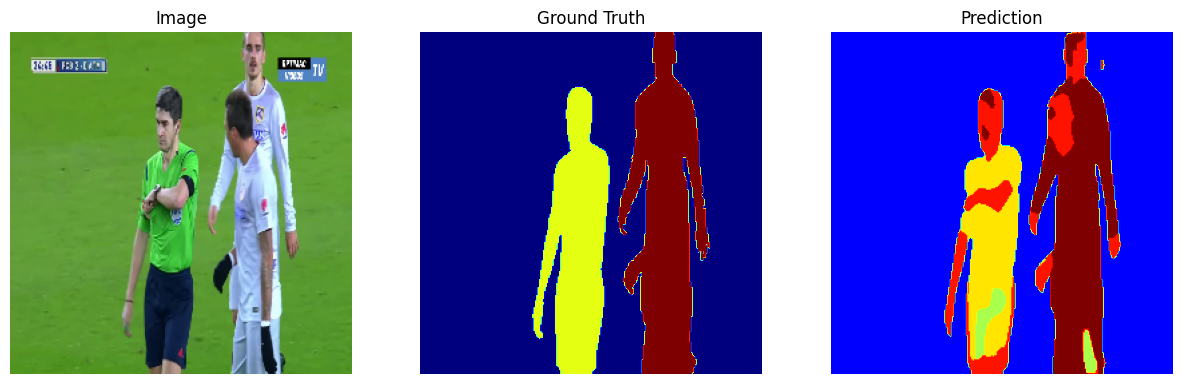

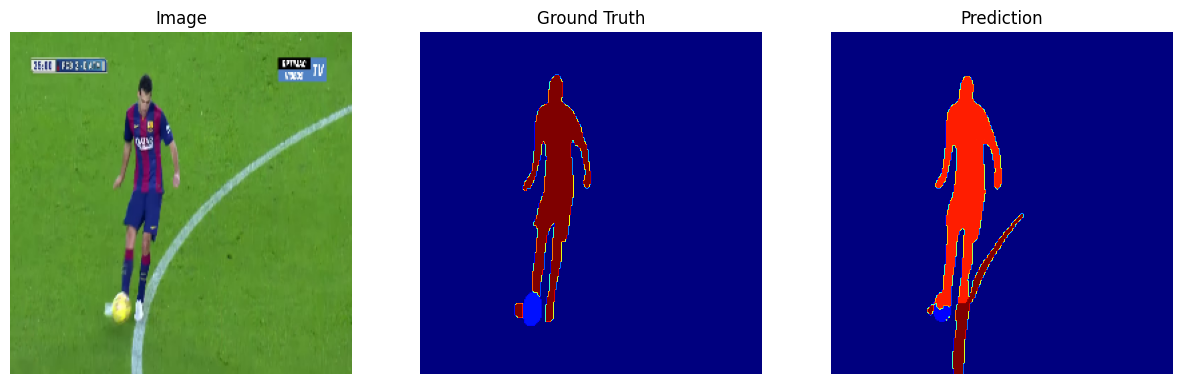

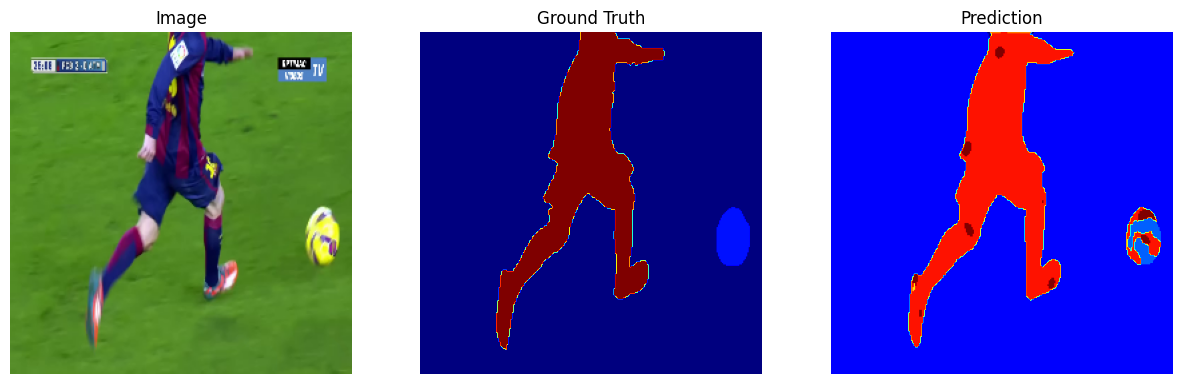

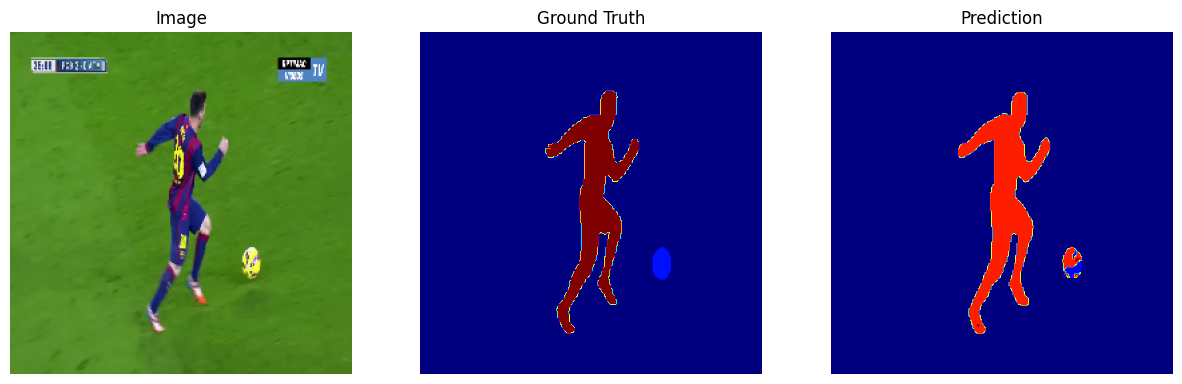

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_sample(image, mask, pred_mask):
    """
    Plots the original image, ground truth mask, and predicted mask.
    
    Args:
        image (np.array): Original image of shape (256, 256, 3).
        mask (np.array): Ground truth mask of shape (256, 256).
        pred_mask (np.array): Predicted mask of shape (256, 256).
    """
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.axis('off')
    
    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(mask, cmap='jet')  # Use a colormap for better visualization
    plt.axis('off')
    
    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred_mask, cmap='jet')  # Use a colormap for better visualization
    plt.axis('off')
    
    plt.show()

# Select a few samples for prediction
sample_indices = range(7)  # Select the first 5 samples
sample_images = []
sample_masks = []

for idx in sample_indices:
    # Load image
    img_path = os.path.join(image_folder, image_files[idx])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Unable to load image at {img_path}. Skipping.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load mask
    mask_path = os.path.join(mask_folder, mask_files[idx])
    mask = cv2.imread(mask_path)
    if mask is None:
        print(f"Warning: Unable to load mask at {mask_path}. Skipping.")
        continue
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # Convert mask to label indices
    mask_label = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, label in rgb_to_label.items():
        mask_label[(mask == rgb).all(axis=-1)] = label
    
    sample_images.append(img)
    sample_masks.append(mask_label)

# Ensure the images are in the correct shape and type
sample_images = [cv2.resize(img, (256, 256)) for img in sample_images]
sample_images = np.array(sample_images, dtype=np.float32) / 255.0

# Resize ground truth masks to match the model output size
sample_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) for mask in sample_masks]
sample_masks = np.array(sample_masks, dtype=np.uint8)

# Predict using the model
pred_masks = model.predict(sample_images)  # Output shape: (batch_size, 256, 256, num_classes)
pred_masks = np.argmax(pred_masks, axis=-1)  # Convert to class labels

# Plot the results
for img, true_mask, pred_mask in zip(sample_images, sample_masks, pred_masks):
    plot_sample(img, true_mask, pred_mask)